# Random Forest (Ensemble Model)

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
from sklearn.model_selection import TimeSeriesSplit

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

### (Part0) Data Preparation & Helper Function

We will use Apple Stock Price data from 2021-12-29 to 2021-4-28 (4month). We will include all the technical features we produced to perform feature selection. 

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', start_date = '2021-12-29', sentiment = False):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index=df['Date']
    data = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if sentiment:
        df.index = np.array(range(len(df)))
        df_sentiment = pd.read_csv('data/AAPL_byday_RoBERTa.csv')
        df_sentiment.date = df_sentiment.date.apply(convert)
        df_sentiment.rename(columns={'date':'Date'}, inplace=True)
        df=df.merge(df_sentiment, how='left', on='Date').fillna(0)

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)

    cols = X.columns
    
    X = np.array(X)
    X = X.astype(np.float32)

    # Split training and validation data
    split = int(0.8 * len(X))
    X_train = X[:split]
    y_train = y[:split]

    return X_train, y_train, cols

In [3]:
def convert(date_string):
    year, month, day = [int(i) for i in date_string.split('-')]
    return datetime(year=year, month=month, day=day)

**Helper Function for Feature Importance Evaluation**

In [4]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    Run random forest and return model and accuracy score. 
    '''
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [5]:
def adaboost(X_train, X_test, y_train, y_test):
    '''
    Run adaboost and return model and accuracy score. 
    '''   
    model = AdaBoostClassifier(random_state=42, n_estimators=100, algorithm='SAMME')
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [6]:
def gradient_boost(X_train, X_test, y_train, y_test):
    '''
    Run gradient boosting and return model and accuracy score. 
    '''       
    model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate = 0.001, max_depth = 3, loss = 'exponential')
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [7]:
def sklearn_cross_validation(df_X, df_y, split, verbose, plot = False):
    '''
    Do cross validation based on ScikitLearn's Time Series Split
    '''
    tscv = TimeSeriesSplit(n_splits=split)

    rf_results = []
    ada_results = []
    gradient_results = []
    rf_feature_imp = np.zeros(df_X.shape[1])
    ada_feature_imp = np.zeros(df_X.shape[1])
    gra_feature_imp = np.zeros(df_X.shape[1])

    for train_index, validation_index in tscv.split(df_X):
        #print("TRAIN:", train_index, "VALIDATION:", validation_index)
        X_train, X_validation = df_X[train_index], df_X[validation_index]
        y_train, y_validation = df_y[train_index], df_y[validation_index]

        t_scaler = MinMaxScaler()
        X_train = t_scaler.fit_transform(X_train)
        X_validation = t_scaler.transform(X_validation)

        if len(np.unique(y_train)) == 1:
            continue

        rf, rf_accuracy, rf_imp = random_forest(X_train, X_validation, y_train, y_validation)
        len(rf_imp)
        rf_results.append(rf_accuracy)
        rf_feature_imp = rf_feature_imp + rf_imp
        ada, ada_accuracy, ada_imp = adaboost(X_train, X_validation, y_train, y_validation)
        ada_results.append(ada_accuracy)
        ada_feature_imp = ada_feature_imp + ada_imp
        gra, gra_accuracy, gra_imp = gradient_boost(X_train, X_validation, y_train, y_validation)
        gradient_results.append(gra_accuracy)
        gra_feature_imp = gra_feature_imp + gra_imp

    rf_feature_imp = rf_feature_imp / split
    ada_feature_imp = ada_feature_imp / split
    gra_feature_imp = gra_feature_imp / split

    if verbose:
        print("Mean Accuracy of Random Forests", sum(rf_results)/len(rf_results))
        print("Mean Accuracy of Adaboost", sum(ada_results)/len(ada_results))
        print("Mean Accuracy of Gradient Boosting", sum(gradient_results)/len(gradient_results))
    
    if plot:
        return sum(rf_results)/len(rf_results), sum(ada_results)/len(ada_results), sum(gradient_results)/len(gradient_results)
    return rf_feature_imp, ada_feature_imp, gra_feature_imp

In [8]:
def feature_importance(importances, columns): 
    feature_names = [i for i in columns]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)
    
    print('Top 20 Best Features : \n')
    print(forest_importances.head(20))
    fig, ax = plt.subplots(figsize=(30,20))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

## Apple

In [9]:
# AAPL : Data with full set of technical features
X_train_AAPL, y_train_AAPL, columns_AAPL = prepare_dataset()

c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [10]:
rf_AAPL, ada_AAPL, gra_AAPL = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.5454545454545455
Mean Accuracy of Adaboost 0.509090909090909
Mean Accuracy of Gradient Boosting 0.4363636363636364


Mean Accuracy of Random Forests 0.4166666666666667
Mean Accuracy of Adaboost 0.5
Mean Accuracy of Gradient Boosting 0.5
Mean Accuracy of Random Forests 0.5454545454545455
Mean Accuracy of Adaboost 0.509090909090909
Mean Accuracy of Gradient Boosting 0.4363636363636364
Mean Accuracy of Random Forests 0.4833333333333333
Mean Accuracy of Adaboost 0.5
Mean Accuracy of Gradient Boosting 0.45


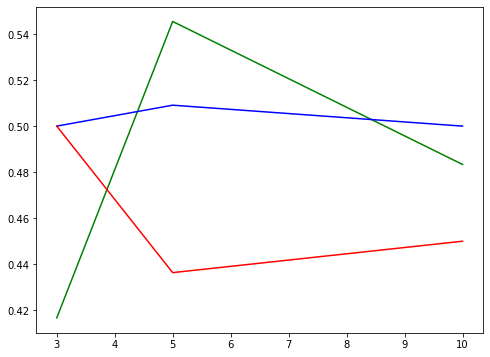

In [13]:
num_folds = [3,5,10]#commonly used k folds
acc_rf = []
acc_ada = []
acc_gb = []

for fold in num_folds:
    rf, ada, gb = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, fold, verbose=True, plot=True)
    acc_rf.append(rf)
    acc_ada.append(ada)
    acc_gb.append(gb)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(num_folds, acc_rf, color = 'Green')
ax.plot(num_folds, acc_ada, color = 'Blue')
ax.plot(num_folds, acc_gb, color = 'Red')

Top 20 Best Features : 

High                     0.032461
volume_nvi               0.023989
Open                     0.023636
volume_vwap              0.021207
trend_vortex_ind_diff    0.020915
momentum_pvo             0.020386
momentum_stoch_rsi_k     0.020207
trend_dpo                0.019764
volume_vpt               0.019516
trend_adx_pos            0.019372
volume_adi               0.018485
volume_em                0.017996
Low                      0.017896
trend_mass_index         0.017721
momentum_pvo_hist        0.017166
trend_sma_fast           0.016392
momentum_stoch           0.015654
momentum_tsi             0.015560
volatility_kch           0.015187
trend_adx                0.014643
dtype: float64


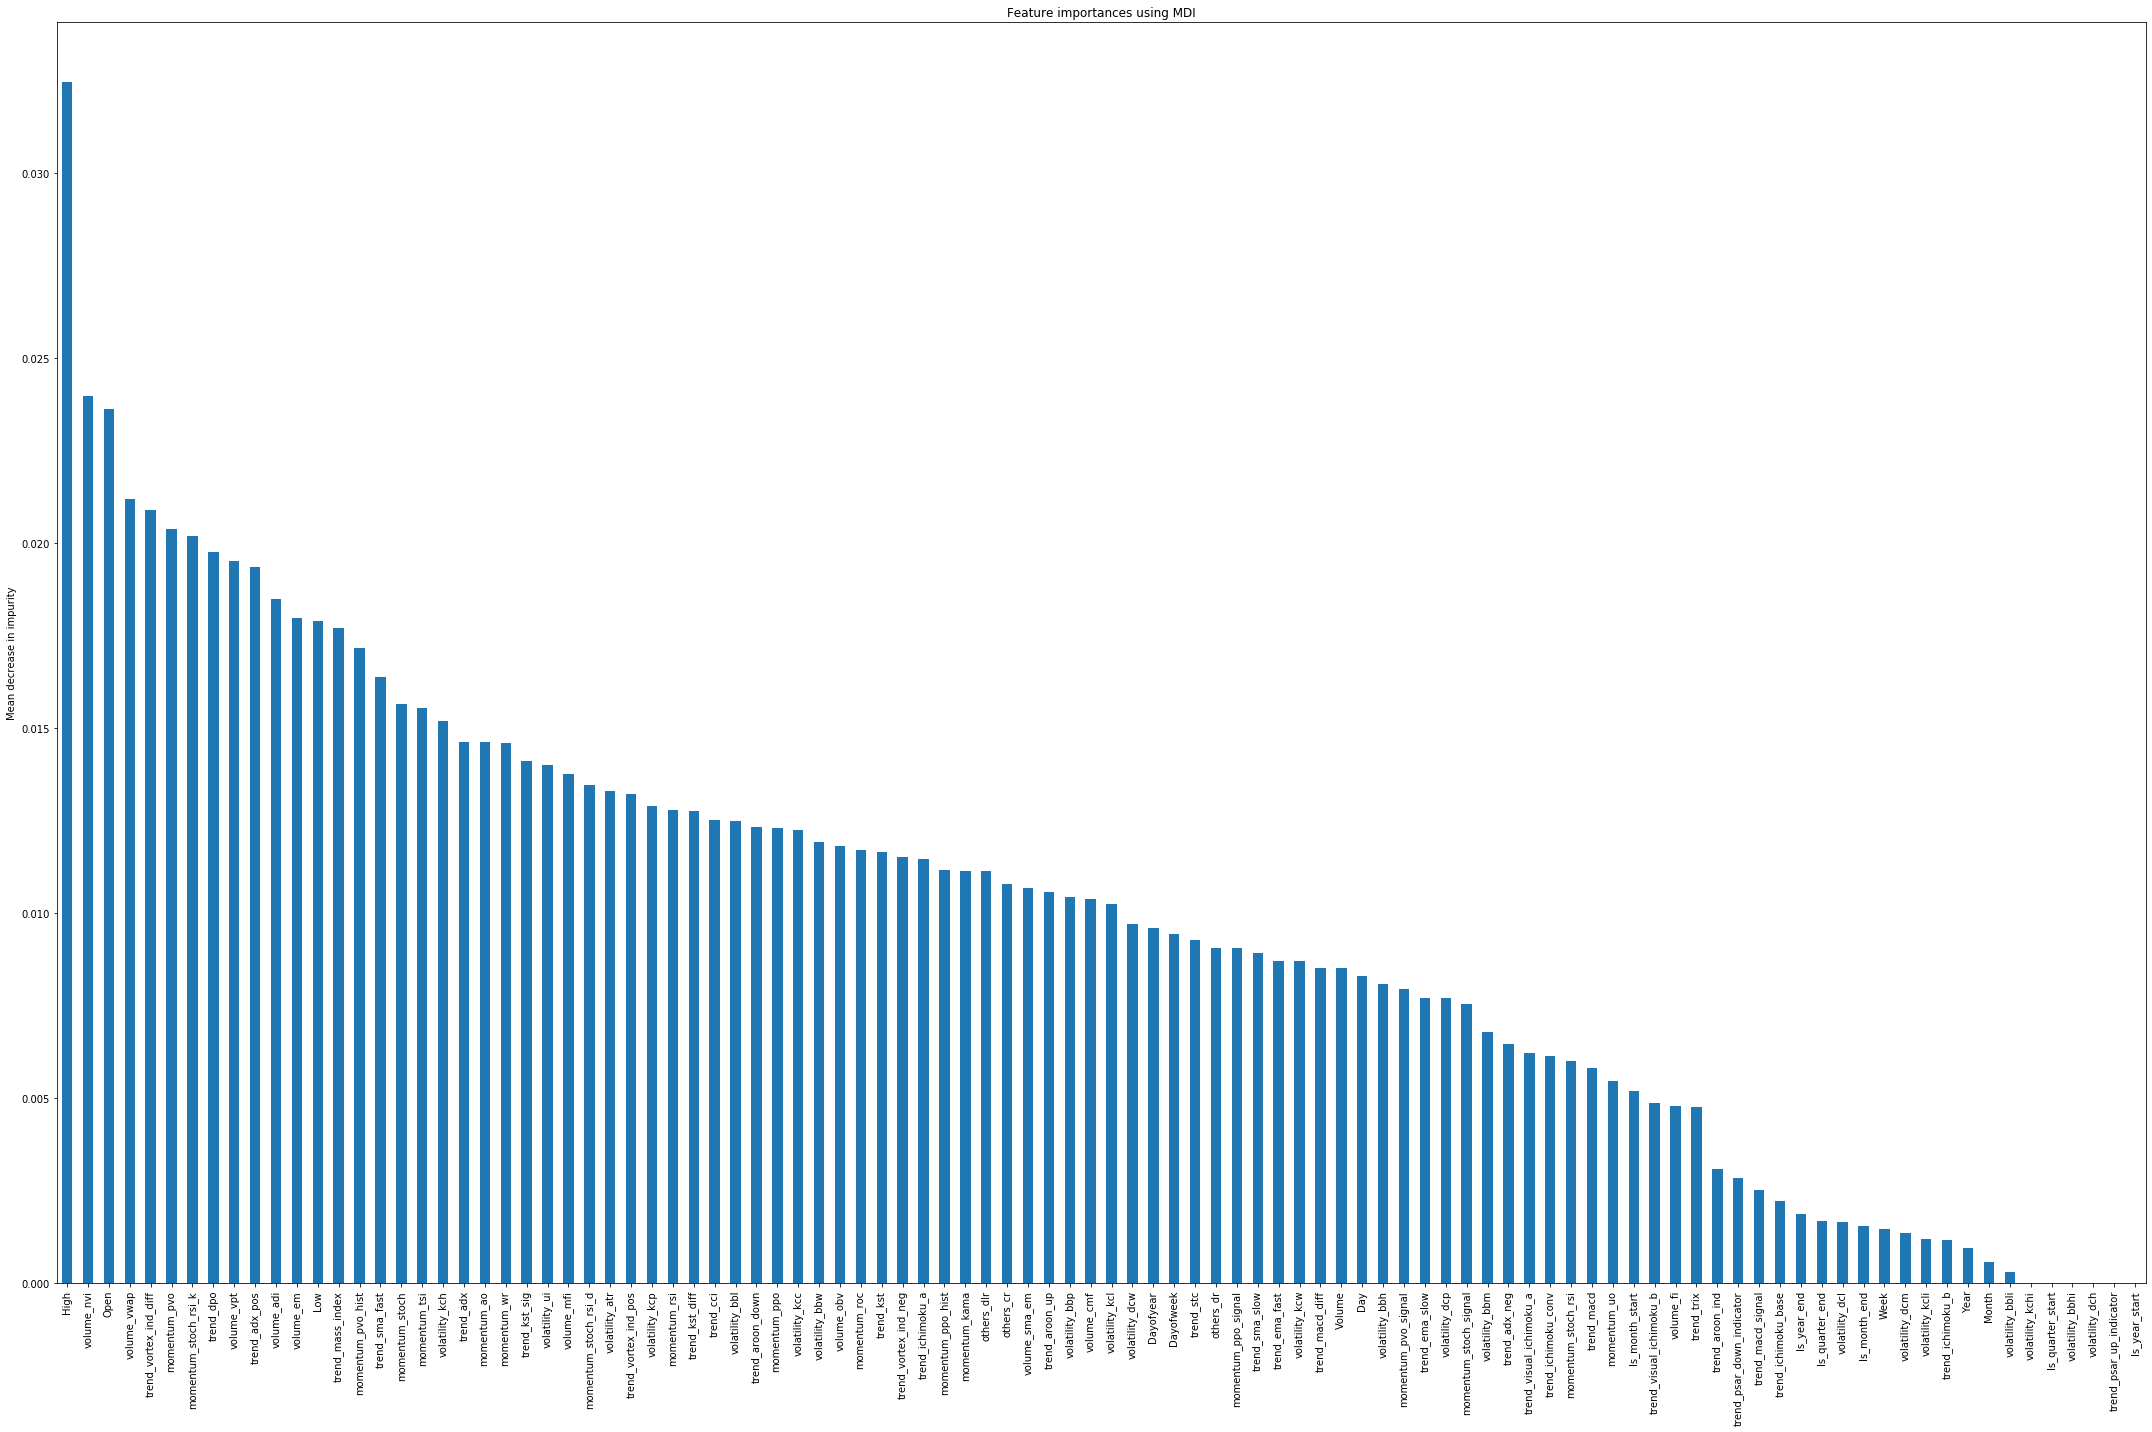

In [14]:
_ = feature_importance(rf_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.095327
momentum_pvo             0.075057
trend_mass_index         0.060608
volume_obv               0.060303
trend_vortex_ind_diff    0.055257
volume_vpt               0.039432
momentum_stoch_signal    0.035320
High                     0.032633
volume_nvi               0.032119
trend_kst_diff           0.026417
trend_aroon_down         0.025082
trend_kst_sig            0.024734
trend_stc                0.021953
trend_aroon_up           0.020123
Dayofweek                0.018152
volatility_bbl           0.017392
momentum_stoch_rsi_d     0.016954
volatility_kcc           0.016787
momentum_pvo_hist        0.015936
trend_sma_fast           0.015385
dtype: float64


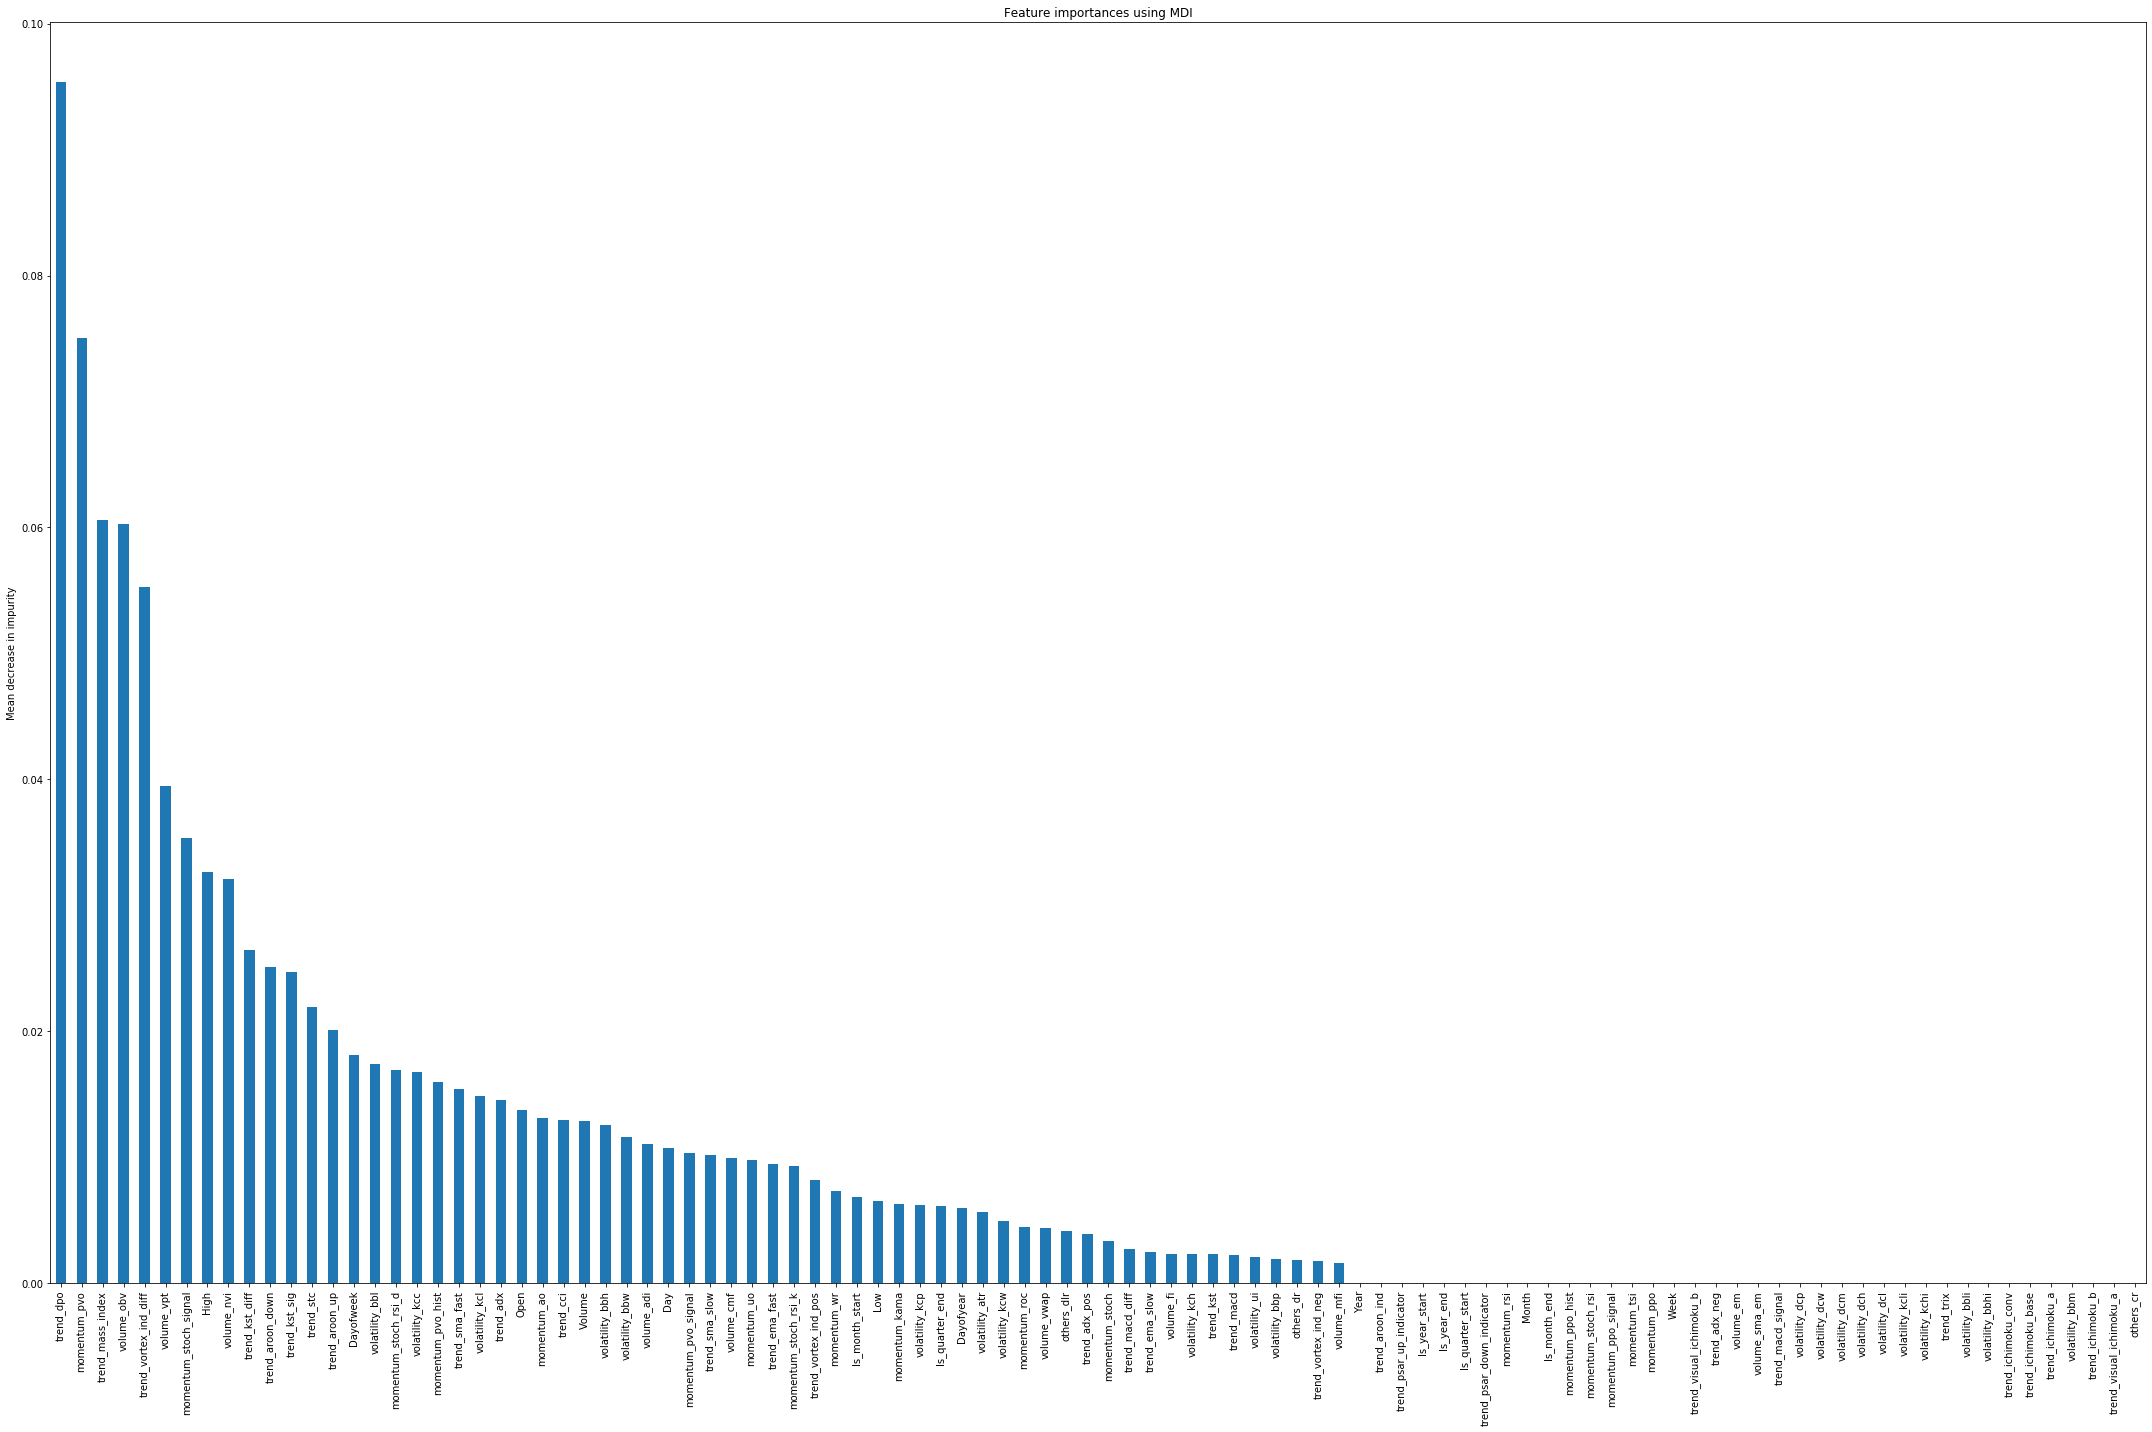

In [15]:
_ = feature_importance(ada_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_mass_index        0.101569
trend_dpo               0.091497
volume_obv              0.080371
trend_kst_sig           0.071962
momentum_pvo            0.060884
trend_sma_fast          0.057394
volume_nvi              0.041884
volatility_ui           0.033138
volume_fi               0.025931
momentum_stoch_rsi_d    0.024503
trend_macd_diff         0.022175
volume_vwap             0.021851
momentum_ppo_hist       0.021002
Low                     0.019533
High                    0.019460
Dayofweek               0.016601
Open                    0.015920
momentum_stoch          0.014361
volatility_kcp          0.013896
trend_adx_pos           0.012368
dtype: float64


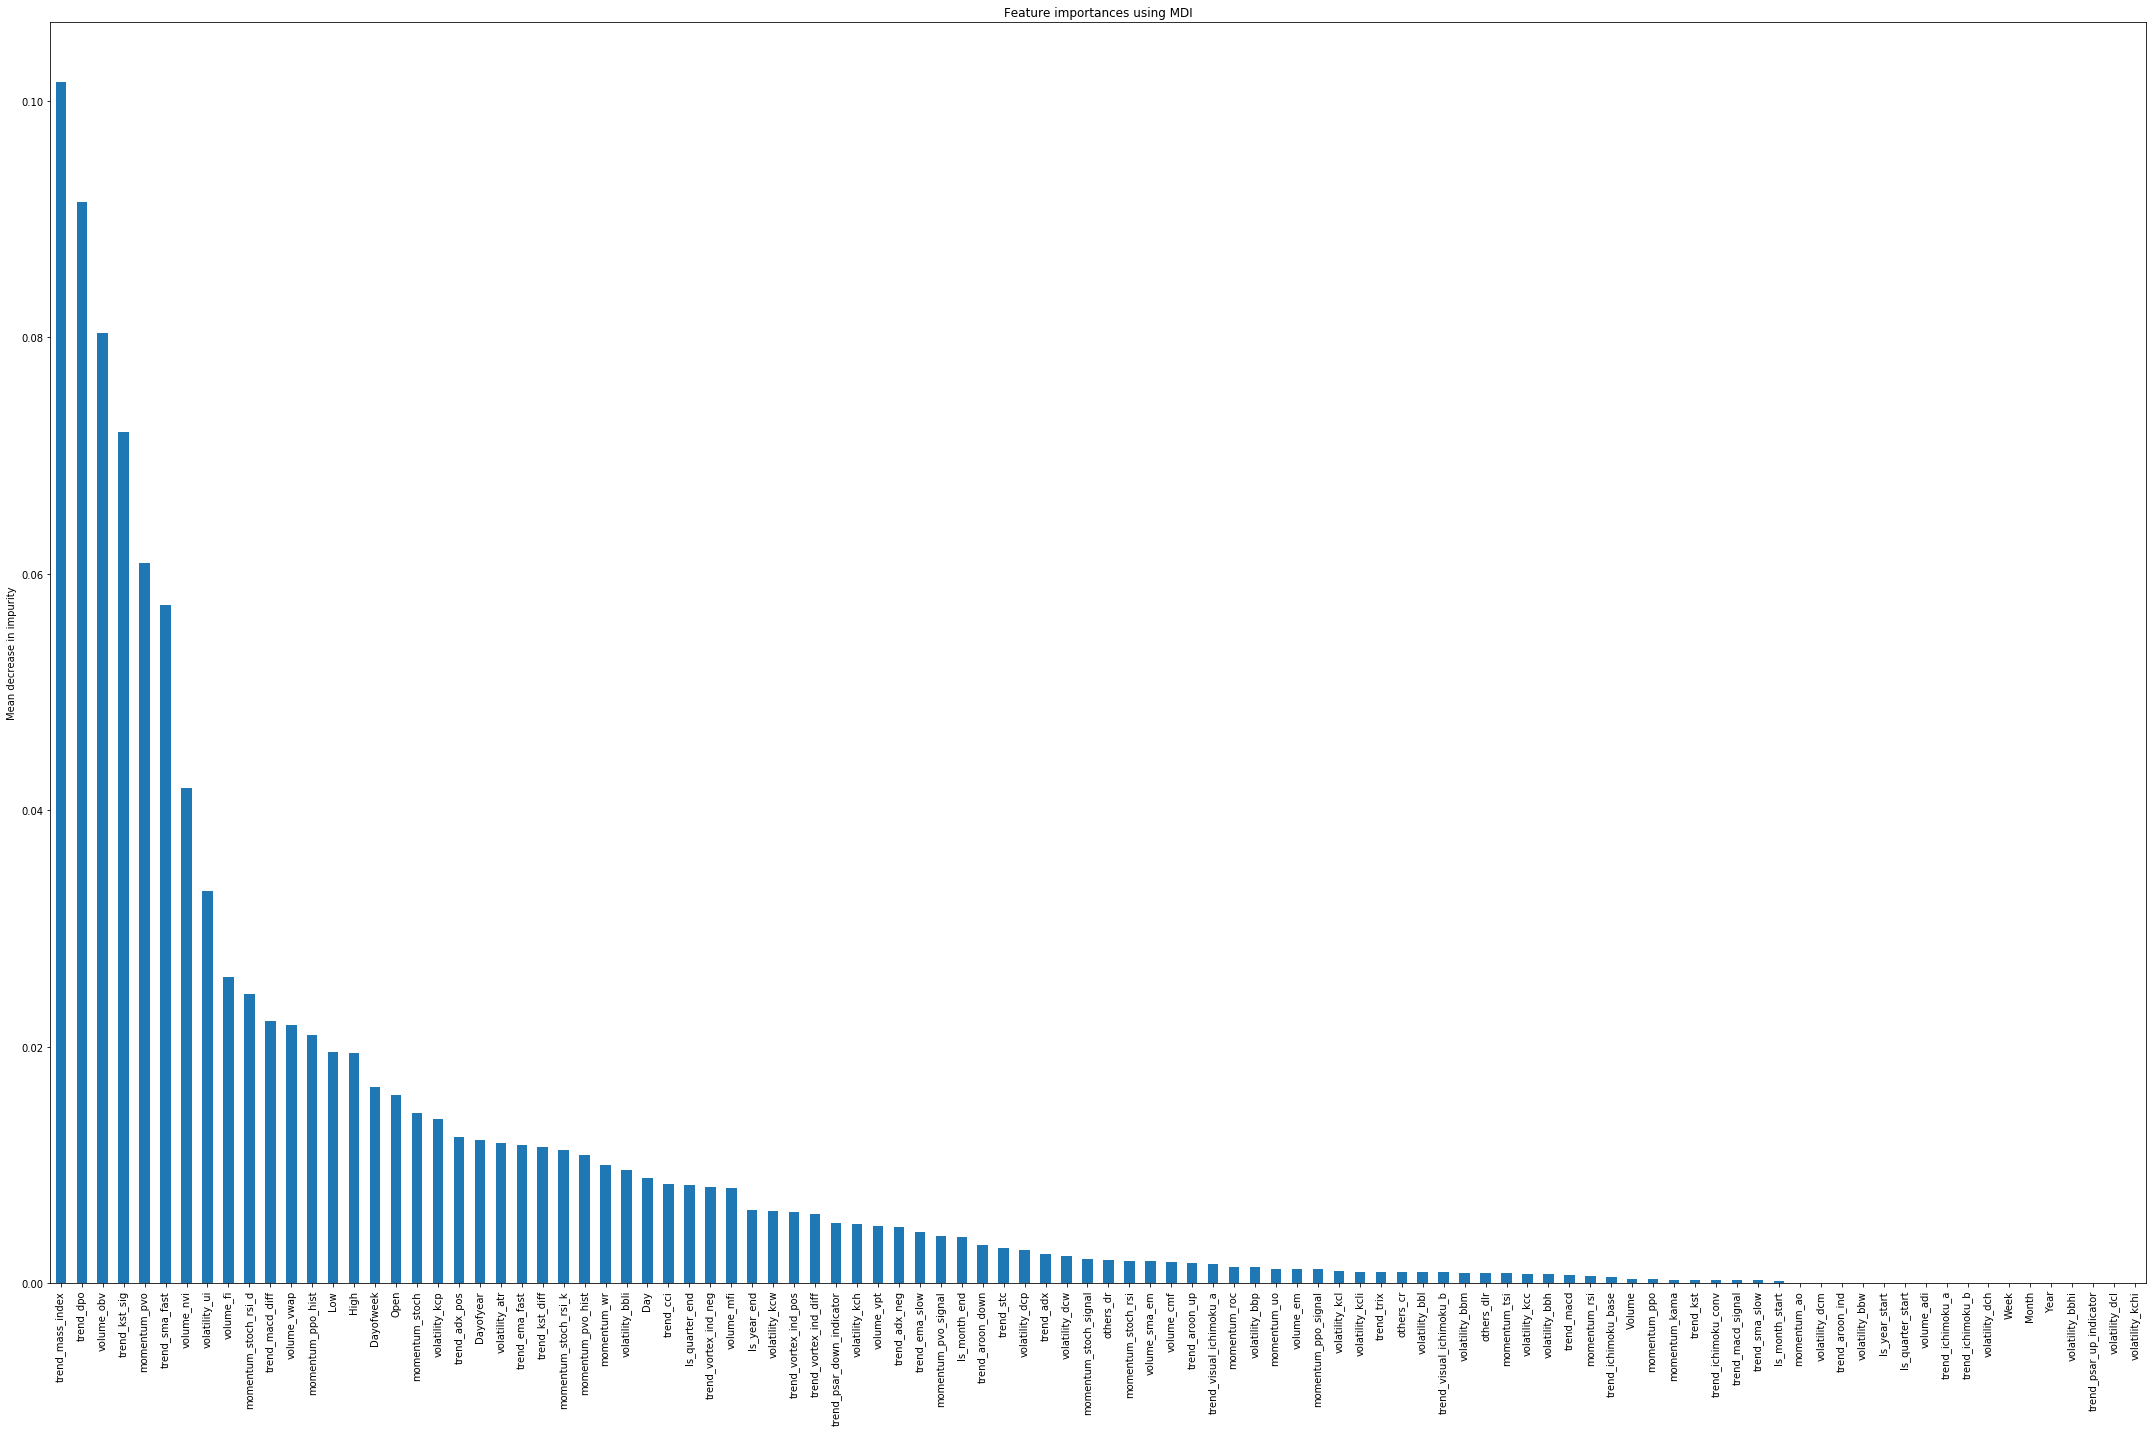

In [16]:
_ = feature_importance(gra_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.068863
trend_mass_index         0.059966
momentum_pvo             0.052109
volume_obv               0.050832
trend_kst_sig            0.036936
volume_nvi               0.032664
trend_sma_fast           0.029724
High                     0.028185
trend_vortex_ind_diff    0.027344
volume_vpt               0.021269
momentum_stoch_rsi_d     0.018309
Open                     0.017768
trend_kst_diff           0.016899
volatility_ui            0.016399
volume_vwap              0.015804
momentum_stoch_signal    0.014965
Dayofweek                0.014733
momentum_pvo_hist        0.014648
Low                      0.014648
momentum_stoch_rsi_k     0.013589
dtype: float64


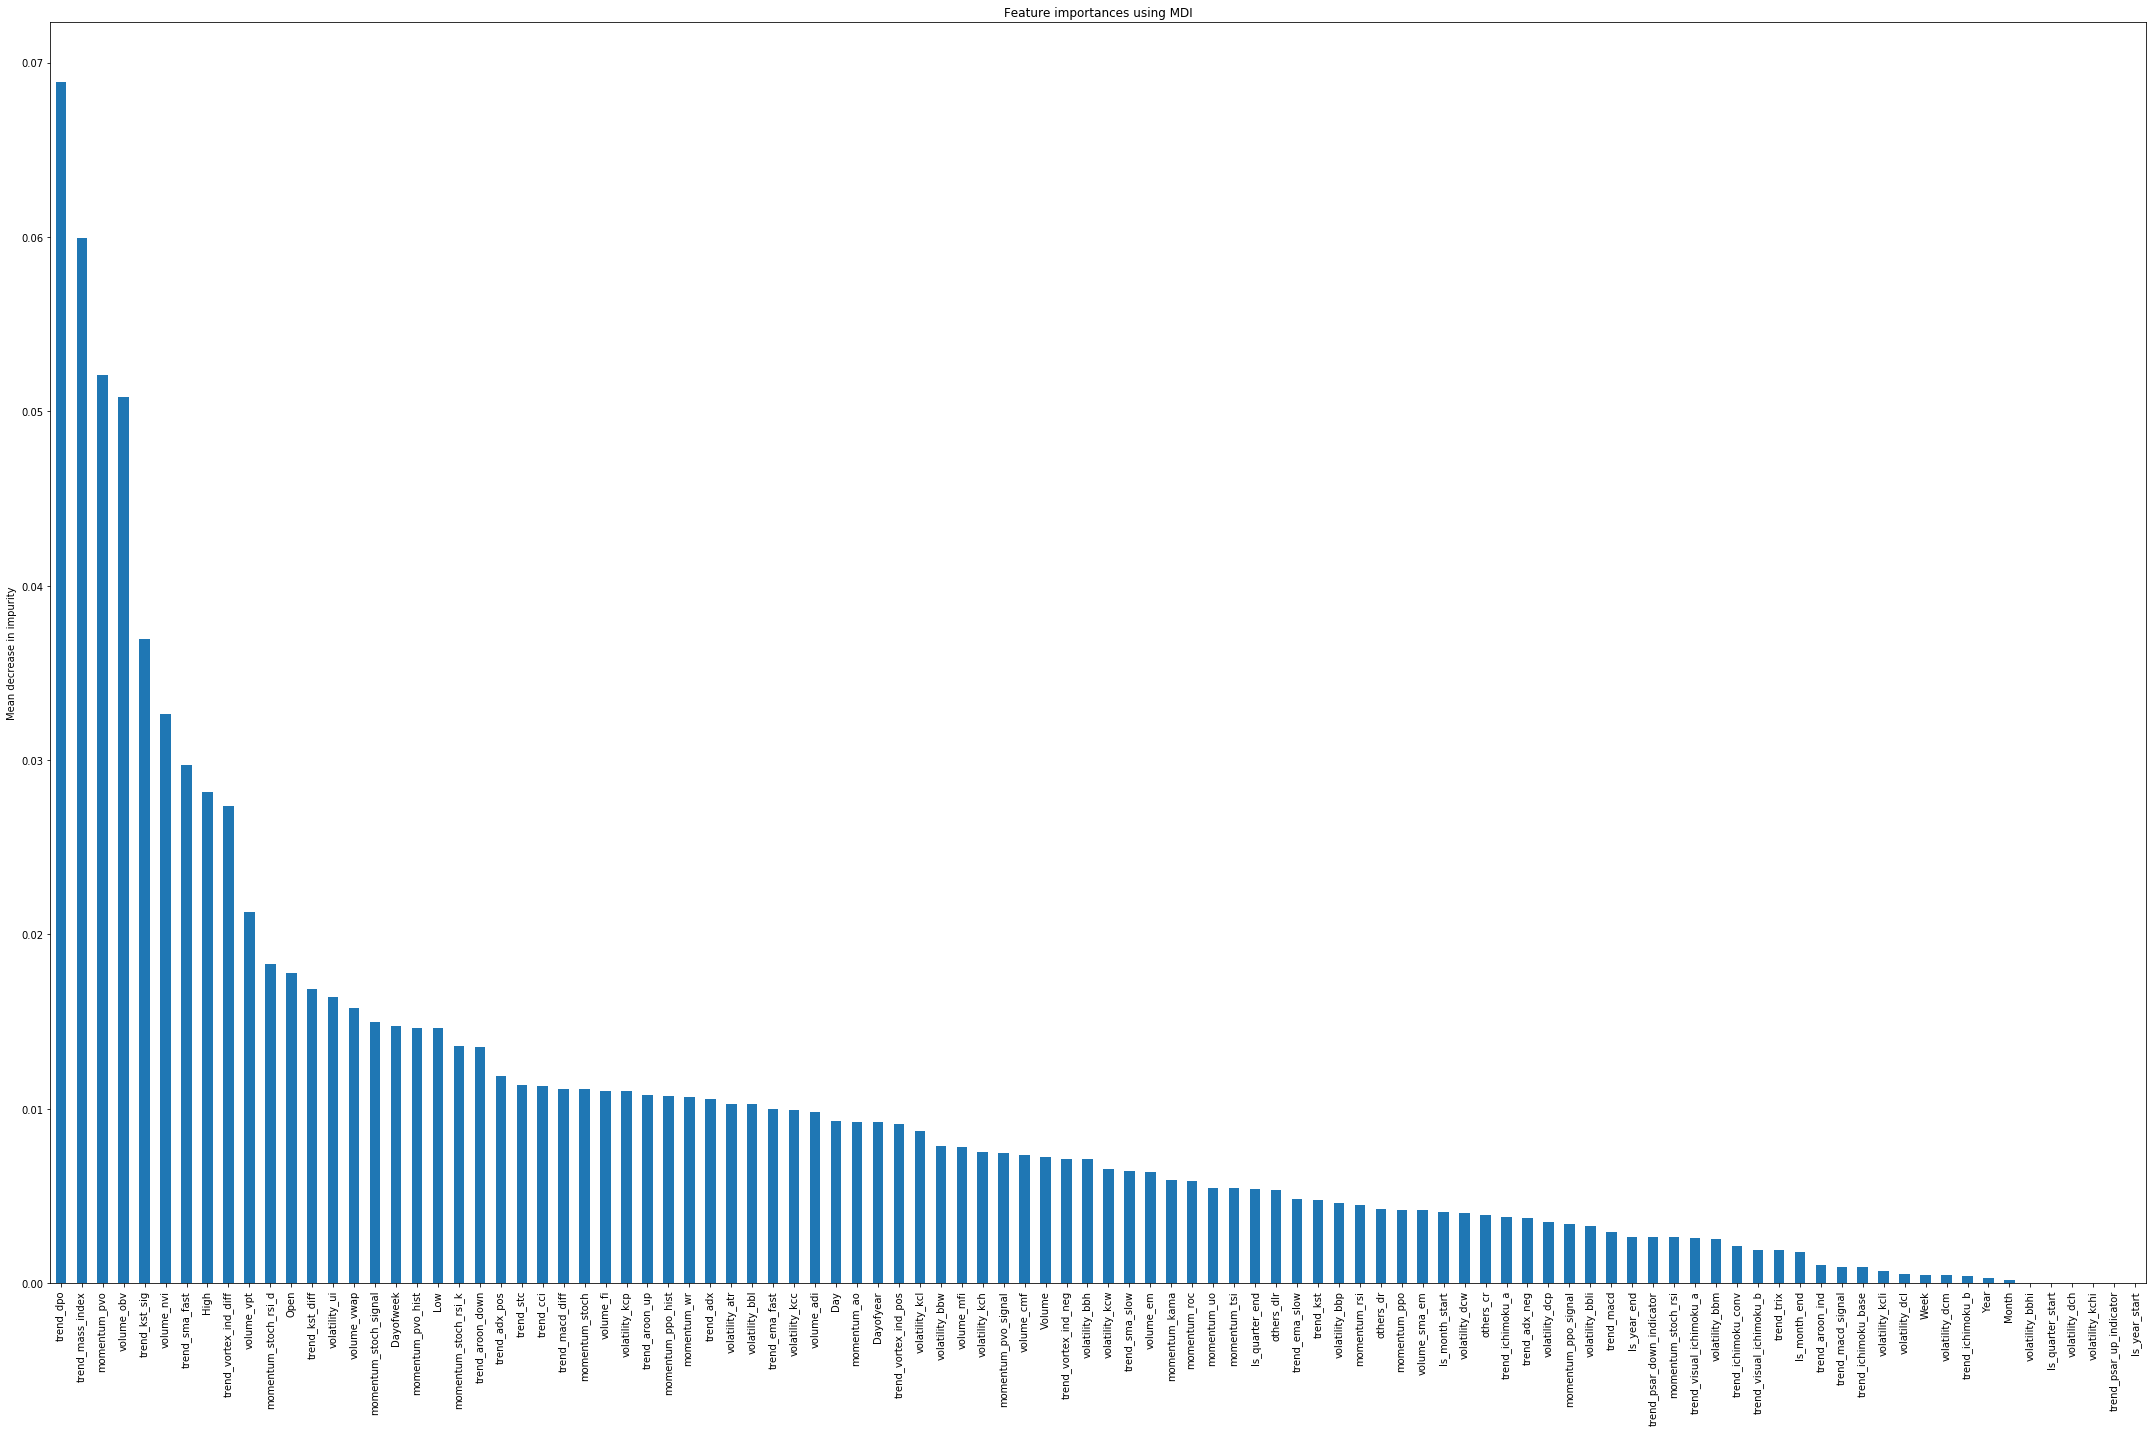

In [17]:
ave_AAPL = (rf_AAPL + ada_AAPL + gra_AAPL) / 3
imp_AAPL = feature_importance(ave_AAPL, columns_AAPL)

## Microsoft

In [18]:
# MSFT : Data with full set of technical features
X_train_MSFT, y_train_MSFT, columns_MSFT = prepare_dataset('data/MSFT_data.csv')

c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [19]:
rf_MSFT, ada_MSFT, gra_MSFT = sklearn_cross_validation(X_train_MSFT, y_train_MSFT, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.4545454545454546
Mean Accuracy of Adaboost 0.41818181818181815
Mean Accuracy of Gradient Boosting 0.47272727272727266


Top 20 Best Features : 

others_cr               0.088221
momentum_ppo_hist       0.056658
trend_adx_pos           0.047338
volume_nvi              0.039314
trend_aroon_ind         0.033898
High                    0.032421
trend_adx_neg           0.031733
trend_vortex_ind_pos    0.026085
volatility_kcp          0.024996
momentum_rsi            0.024556
trend_macd_signal       0.023060
Low                     0.022806
momentum_roc            0.022623
momentum_wr             0.021588
volume_adi              0.021006
volume_cmf              0.019286
volatility_bbh          0.019007
momentum_stoch_rsi_k    0.017610
volatility_bbp          0.017610
momentum_pvo_hist       0.017538
dtype: float64


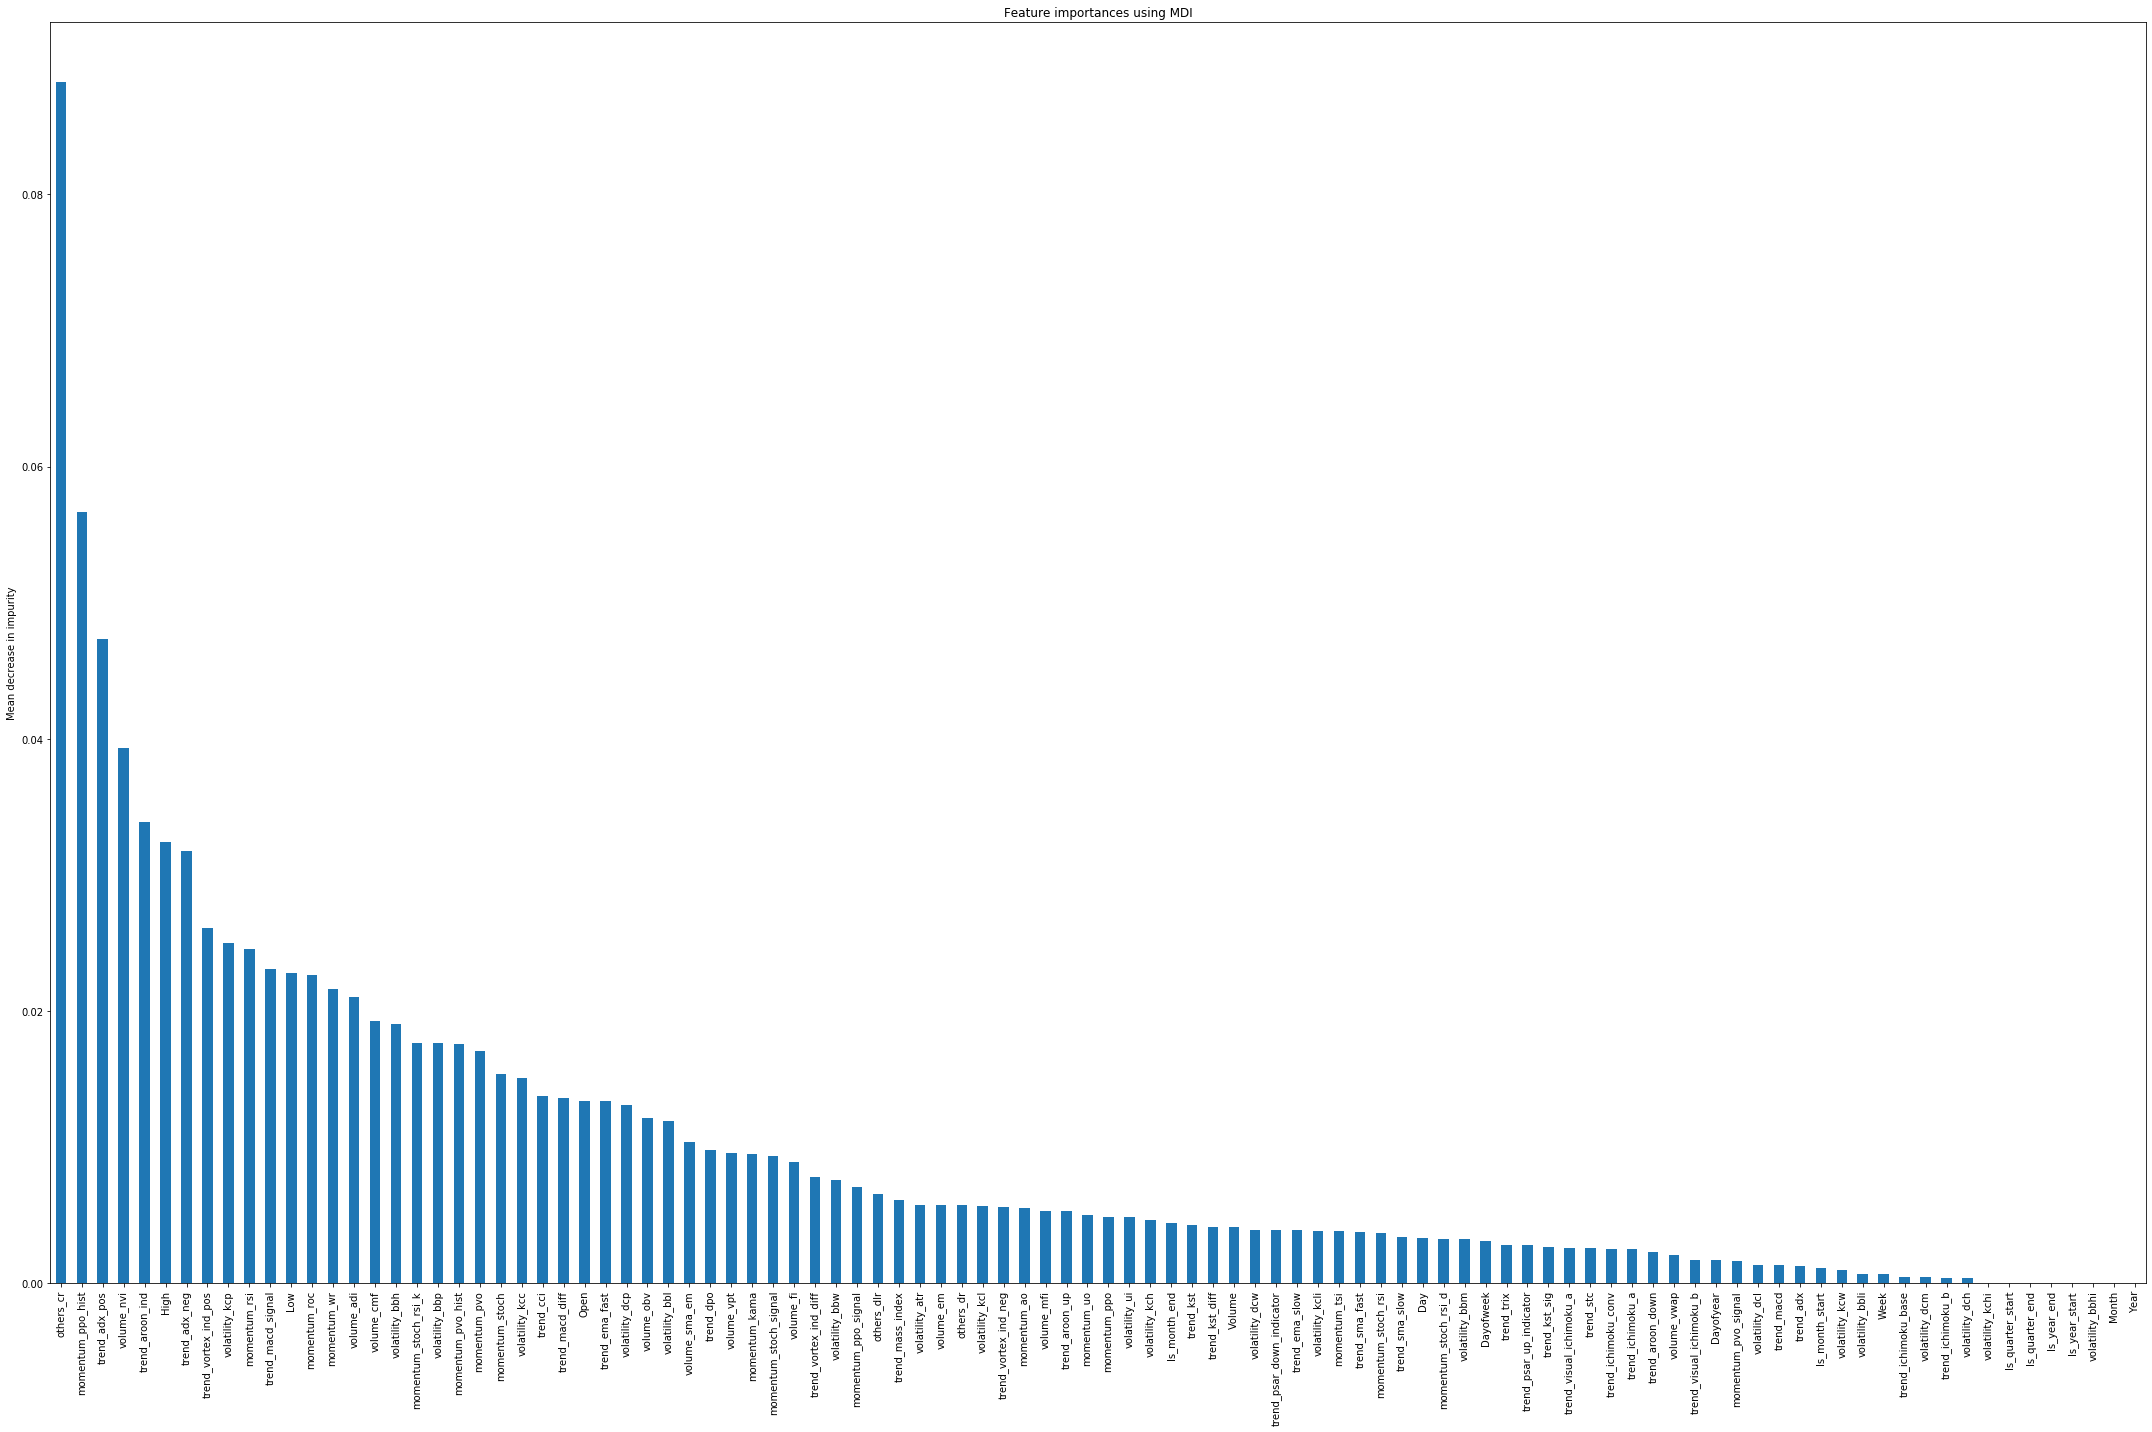

In [20]:
ave_MSFT = (rf_MSFT + ada_MSFT + gra_MSFT) / 3
imp_MSFT = feature_importance(ave_MSFT, columns_MSFT)

## NVDIA

In [21]:
# NVDA : Data with full set of technical features
X_train_NVDA, y_train_NVDA, columns_NVDA = prepare_dataset('data/NVDA_data.csv')

c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [24]:
rf_NVDA, ada_NVDA, gra_NVDA = sklearn_cross_validation(X_train_NVDA, y_train_NVDA, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.4909090909090909
Mean Accuracy of Adaboost 0.47272727272727266
Mean Accuracy of Gradient Boosting 0.43636363636363634


Top 20 Best Features : 

trend_aroon_ind          0.086464
others_dlr               0.058611
others_dr                0.057204
momentum_rsi             0.040902
others_cr                0.038196
volatility_atr           0.036554
trend_aroon_up           0.033697
trend_vortex_ind_neg     0.031527
trend_dpo                0.030056
volatility_kcw           0.028592
Volume                   0.028333
volume_adi               0.026638
trend_mass_index         0.020075
trend_vortex_ind_diff    0.017683
volume_vpt               0.017150
volume_obv               0.015546
momentum_stoch_rsi_k     0.015533
volume_vwap              0.014346
momentum_pvo_hist        0.014098
Day                      0.013587
dtype: float64


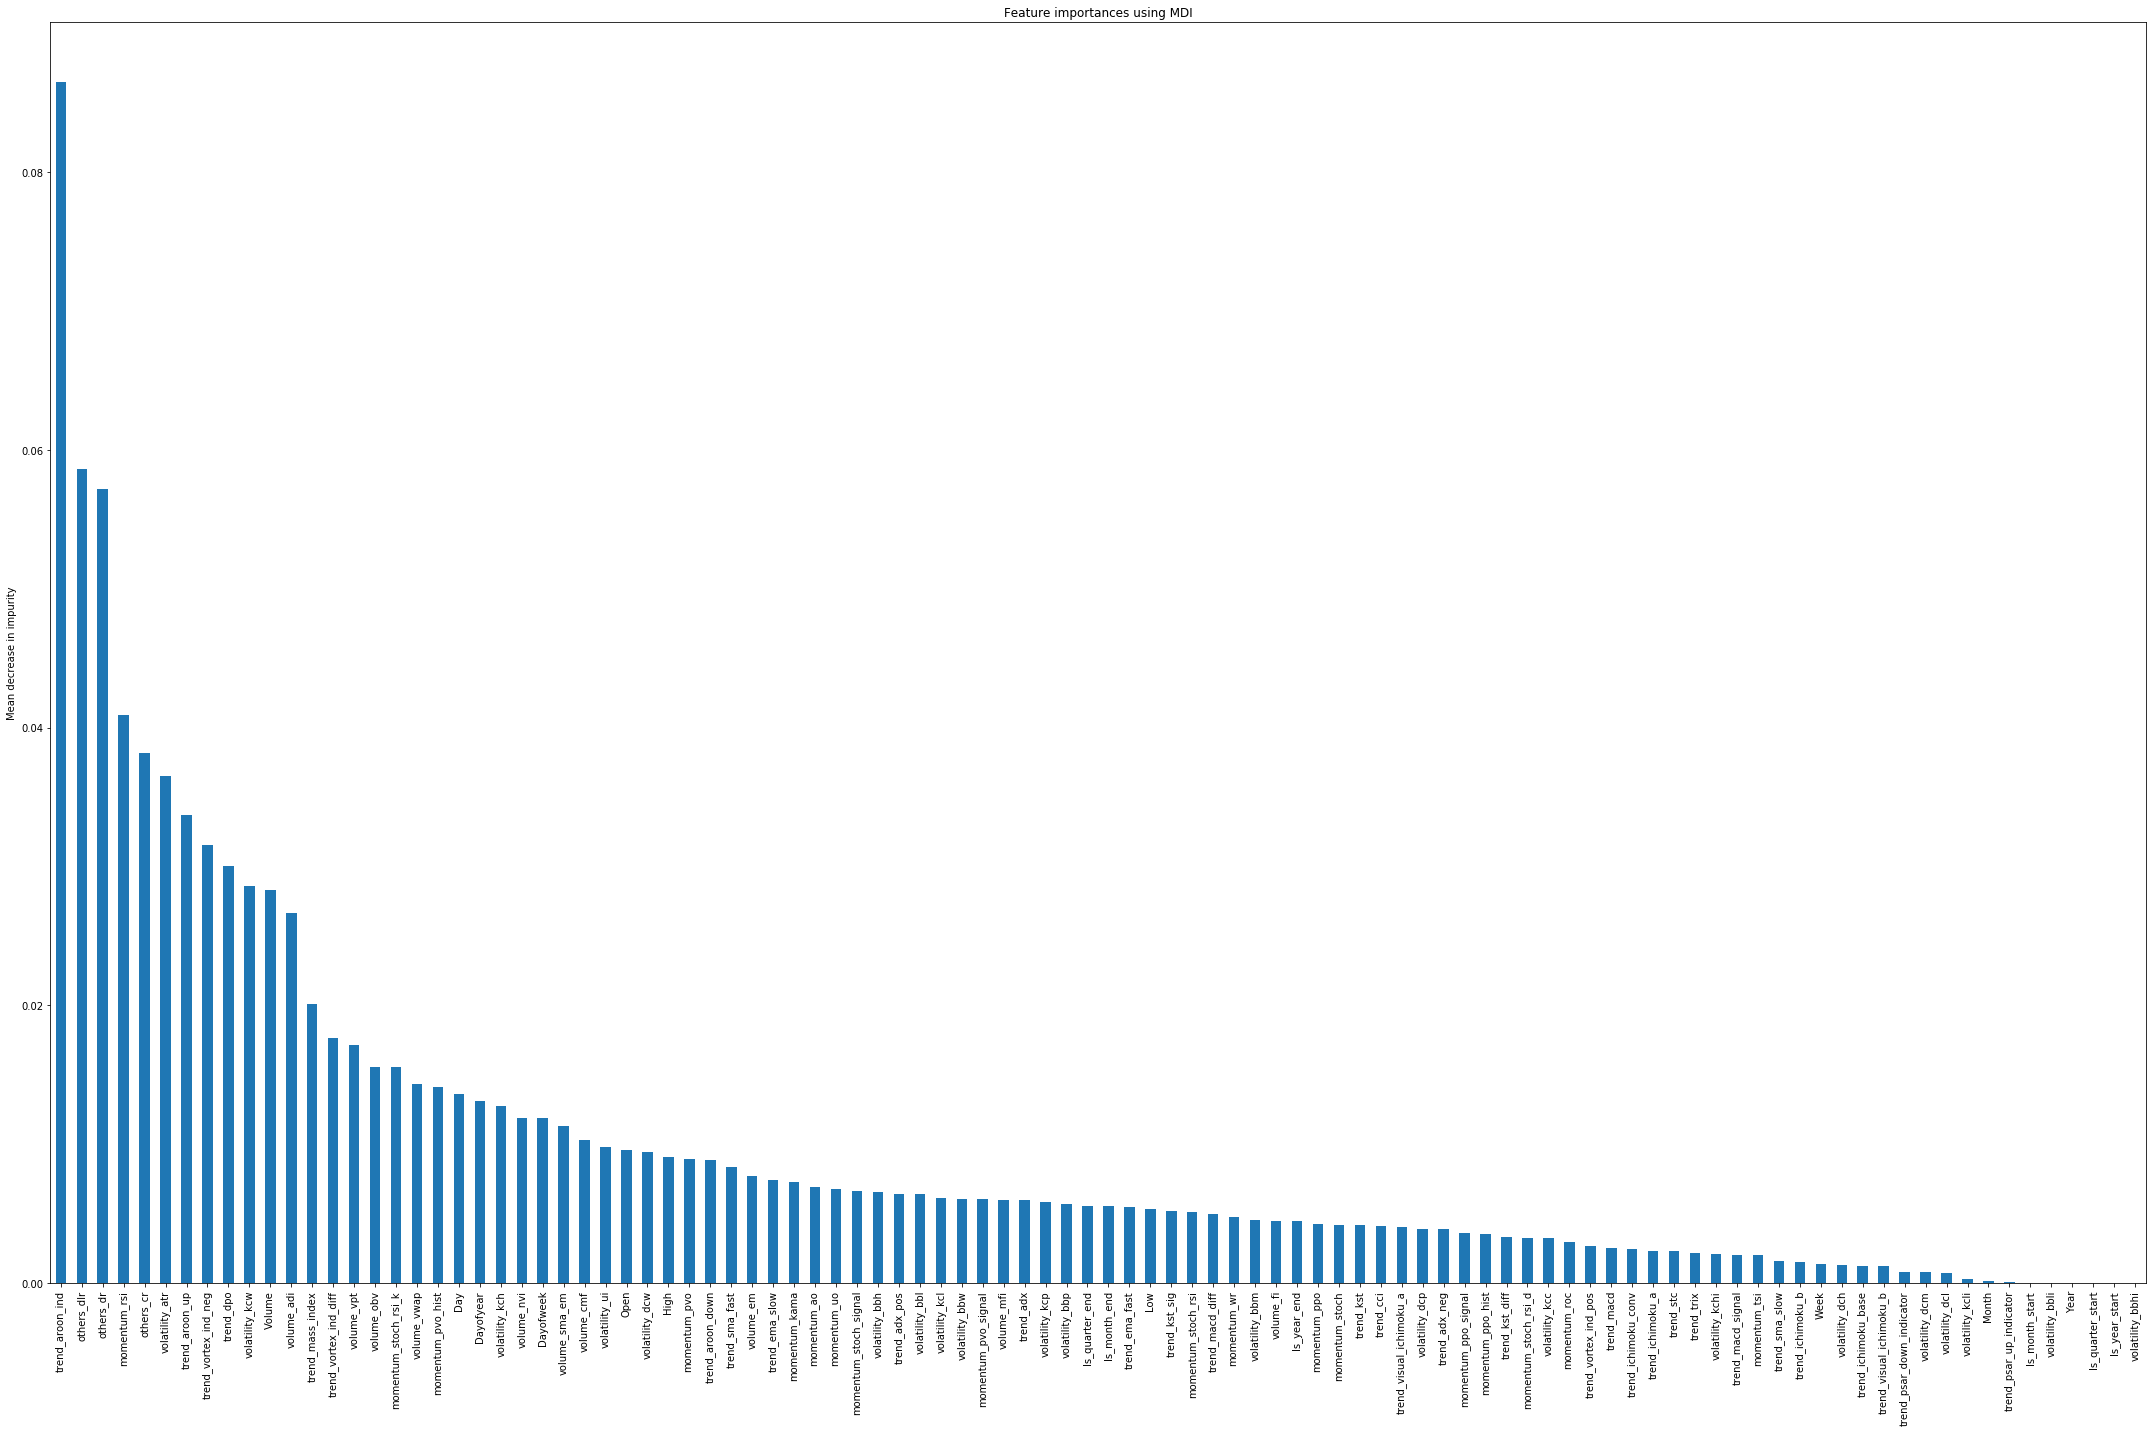

In [25]:
ave_NVDA = (rf_NVDA + ada_NVDA + gra_NVDA) / 3
imp_NVDA = feature_importance(ave_NVDA, columns_NVDA)

## Compare 3 companies feature importance

In [21]:
imp_AAPL.name = "AAPL"
imp_MSFT.name = "MSFT"
imp_NVDA.name = "NVDA"

all_companies = pd.merge(imp_AAPL, imp_MSFT, left_index=True, right_index=True)
all_companies = pd.merge(all_companies, imp_NVDA, left_index=True, right_index=True)

In [22]:
all_companies

,AAPL,MSFT,NVDA
momentum_pvo,0.047836,0.008337,0.006626
trend_dpo,0.041778,0.020859,0.017978
volatility_bbp,0.038273,0.013874,0.006782
Open,0.030135,0.009467,0.013251
momentum_stoch_signal,0.027914,0.007056,0.007301
...,...,...,...
Year,0.000073,0.000000,0.000019
volatility_kchi,0.000059,0.000096,0.001804
volatility_bbhi,0.000000,0.000000,0.000164
Is_quarter_start,0.000000,0.000000,0.000000


<AxesSubplot:>

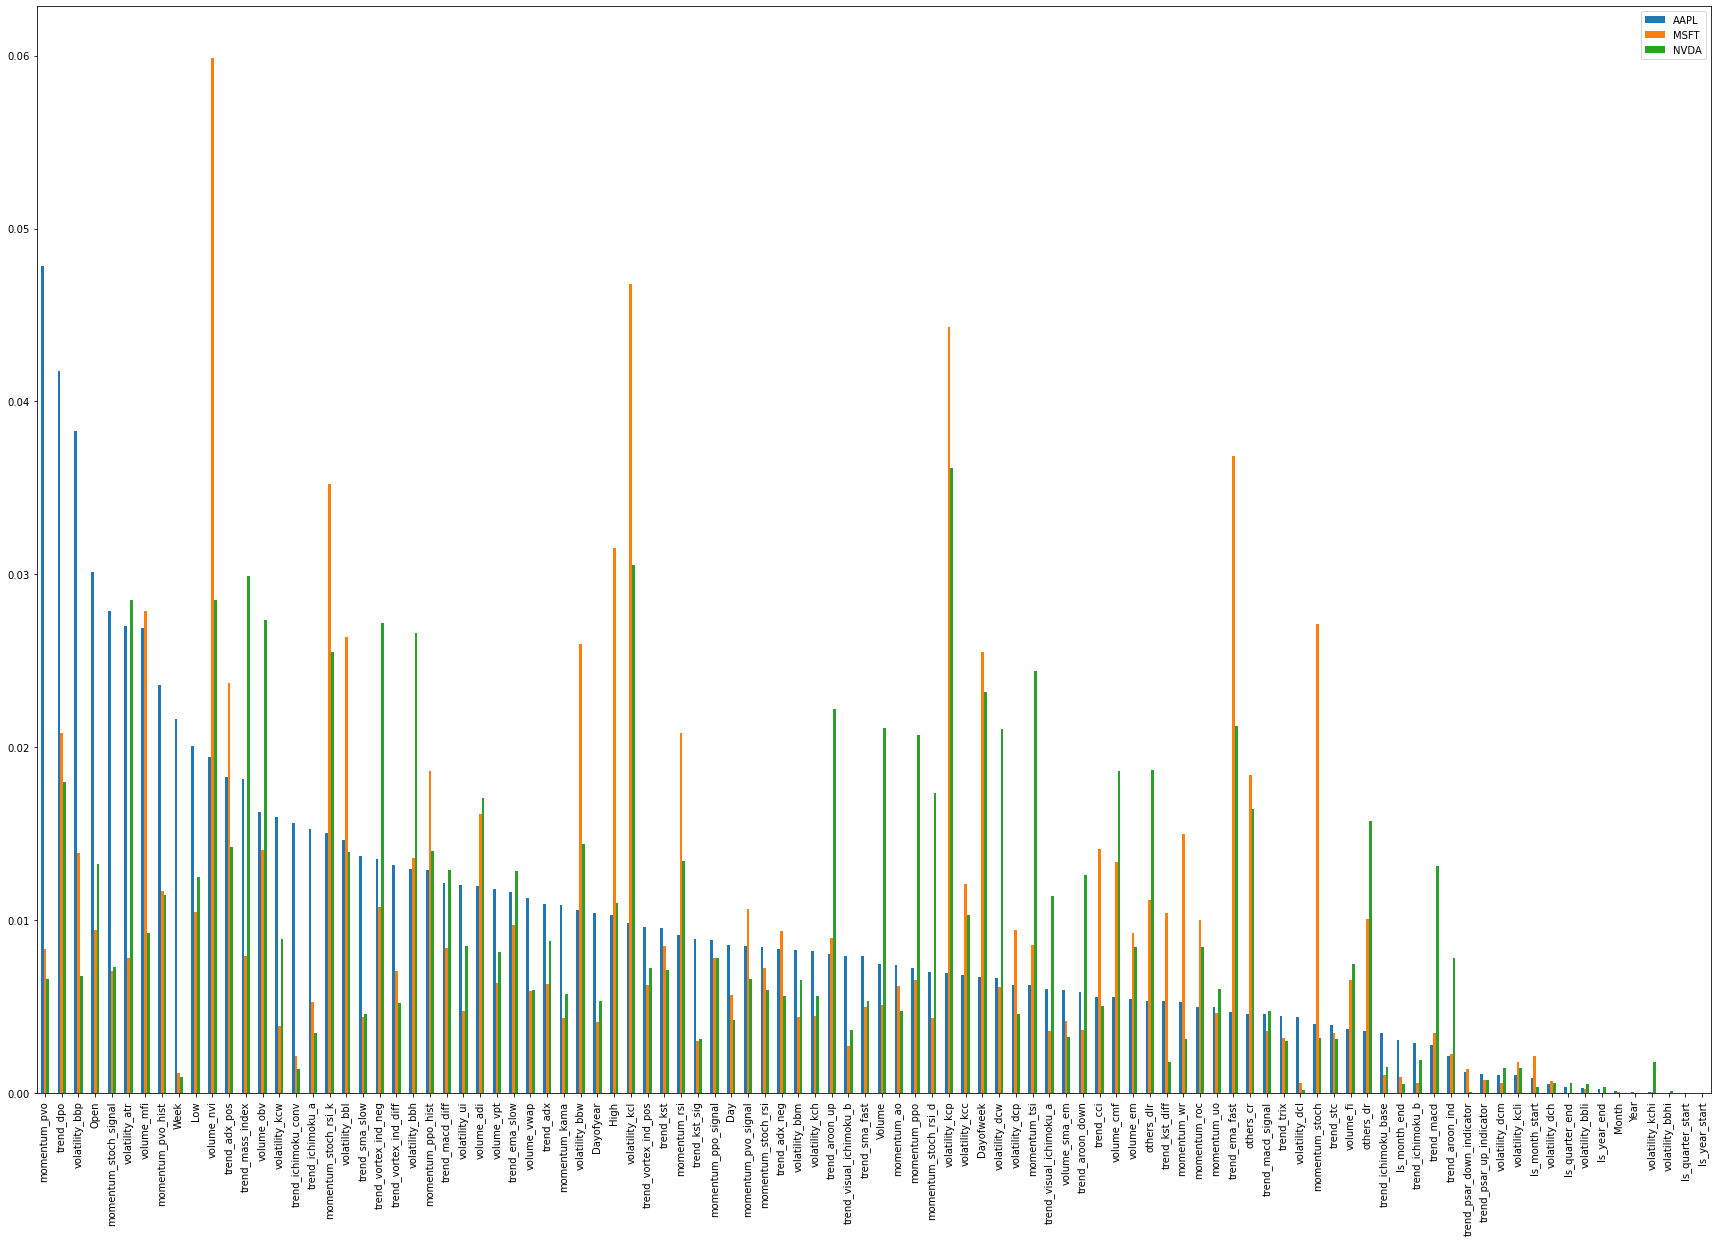

In [23]:
all_companies.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)

## Add Apple RoBERTa

In [26]:
# AAPL : Data with full set of technical features + sentiment score
X_train_AAPLs, y_train_AAPLs, columns_AAPLs = prepare_dataset(sentiment=True)

c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Mean Accuracy of Random Forests 0.4545454545454545
Mean Accuracy of Adaboost 0.509090909090909
Mean Accuracy of Gradient Boosting 0.4363636363636364
Top 20 Best Features : 

trend_dpo                0.067621
trend_mass_index         0.062742
volume_obv               0.046728
momentum_pvo             0.045457
trend_kst_sig            0.037478
trend_sma_fast           0.030304
volume_nvi               0.029765
trend_vortex_ind_diff    0.028580
High                     0.020725
Open                     0.019918
momentum_stoch_rsi_d     0.019825
Dayofweek                0.019488
volume_vpt               0.018951
trend_kst_diff           0.016709
Low                      0.015905
trend_macd_diff          0.015586
volatility_ui            0.015409
volume_vwap              0.014997
momentum_stoch_rsi_k     0.014189
trend_cci                0.013728
dtype: float64


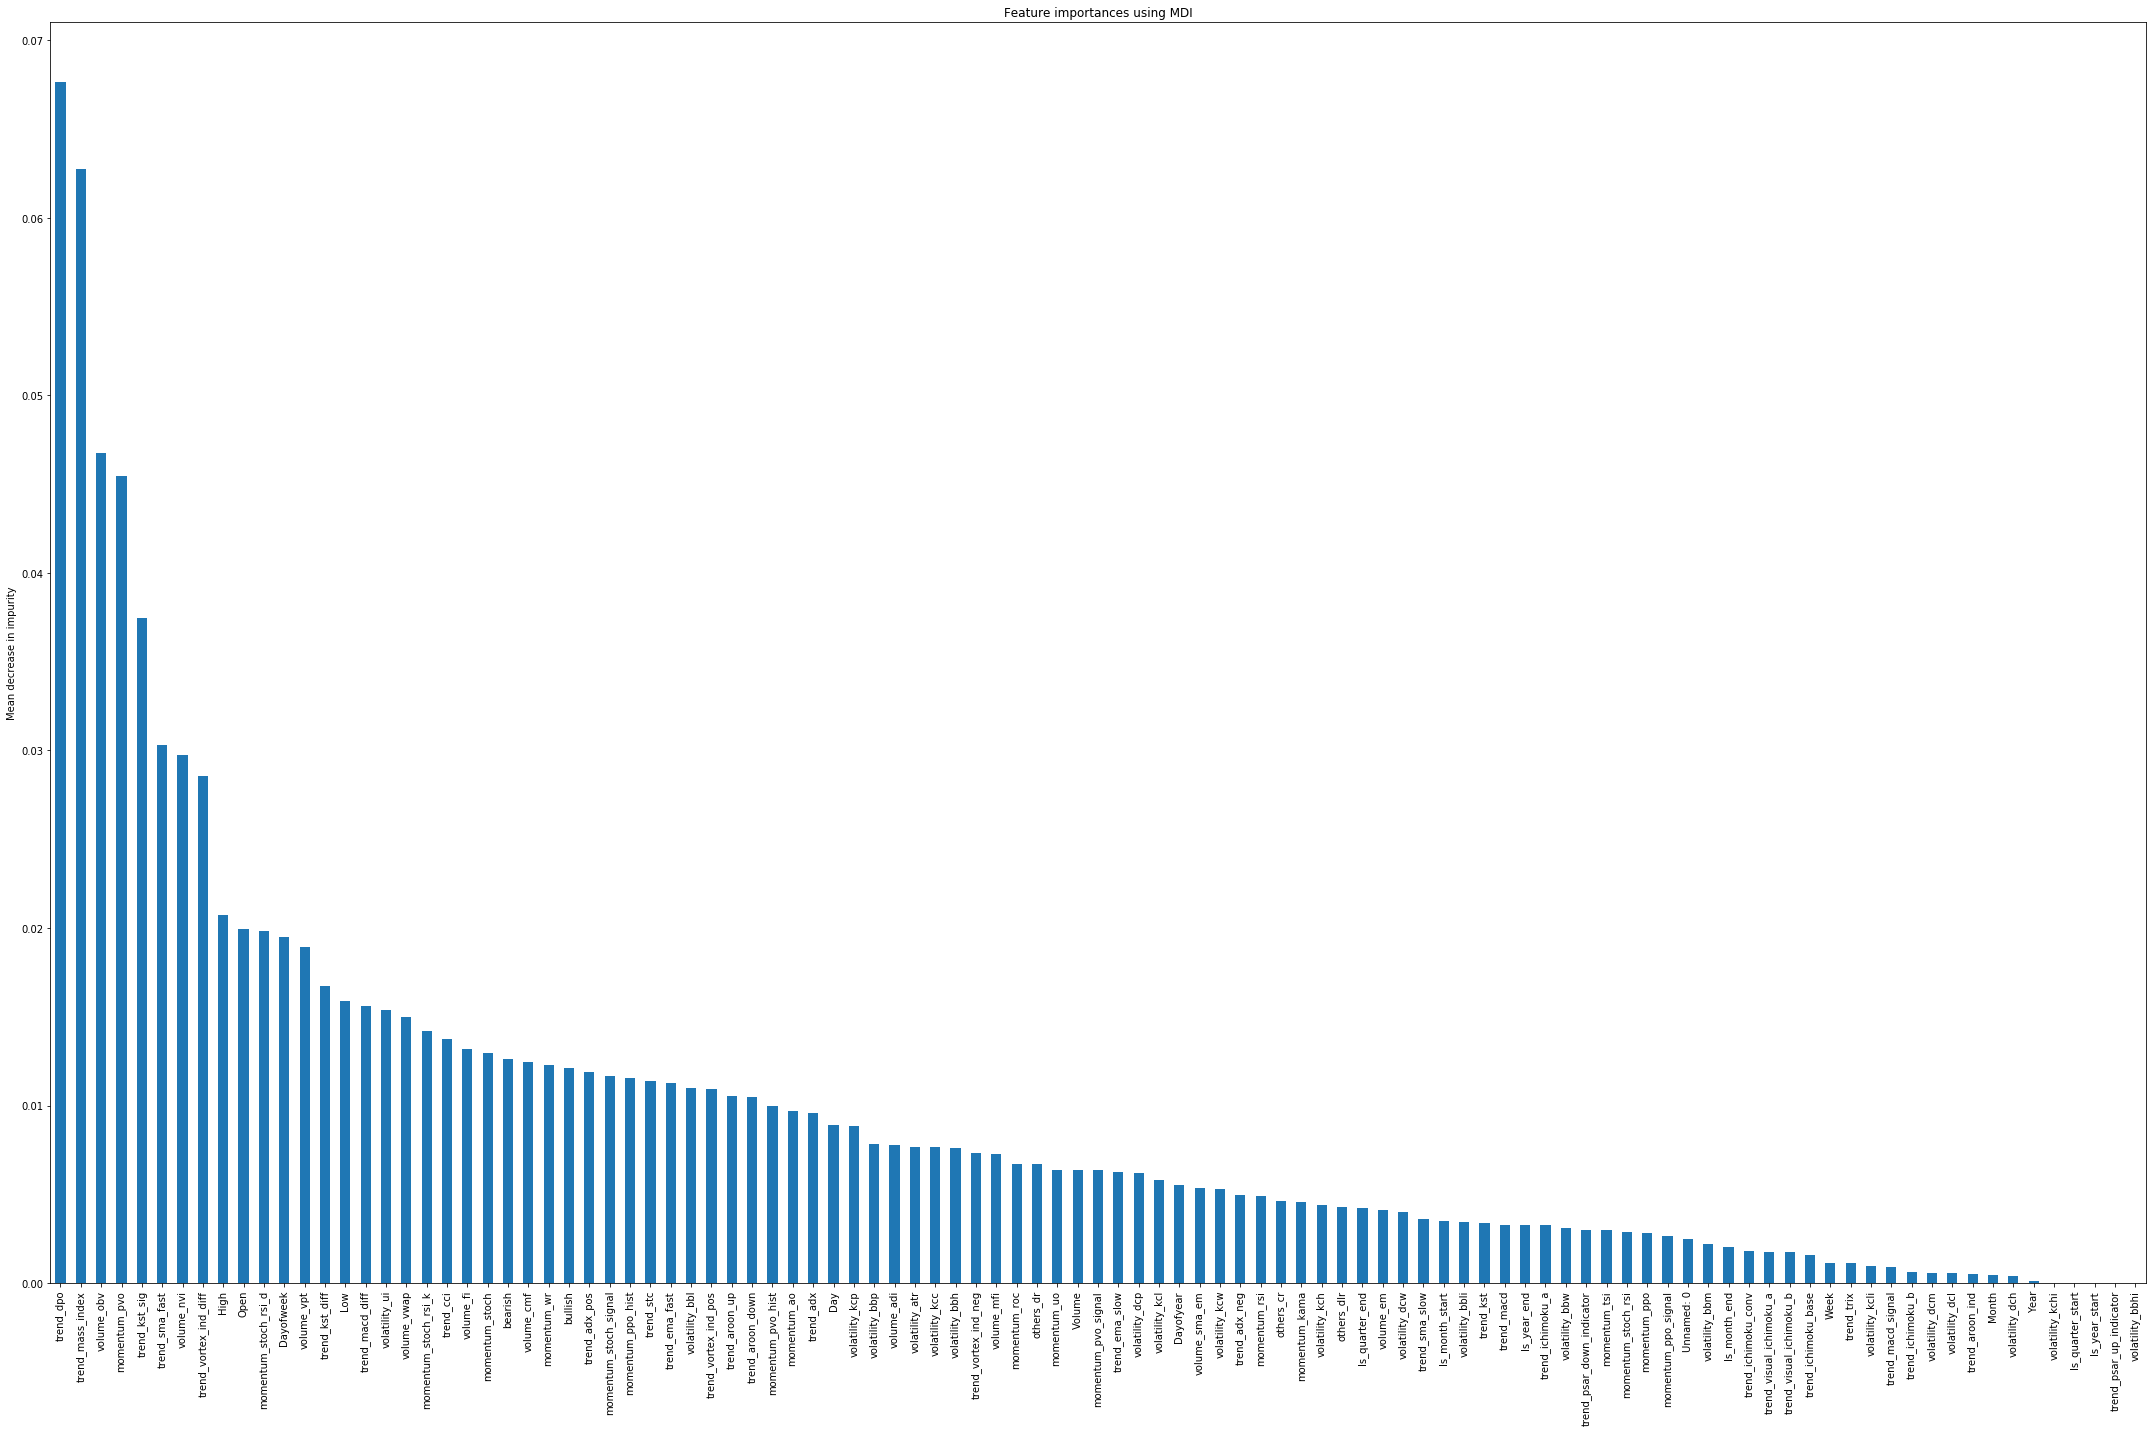

In [27]:
rf_AAPLs, ada_AAPLs, gra_AAPLs = sklearn_cross_validation(X_train_AAPLs, y_train_AAPLs, 5, verbose=True, plot=False)
ave_AAPLs = (rf_AAPLs + ada_AAPLs + gra_AAPLs) / 3
_ = feature_importance(ave_AAPLs, columns_AAPLs)